In [1]:
from plot_classes import *
from matplotlib import transforms

In [2]:
# create boost histogram

v1 = np.random.normal(size=(2, 100_000), scale=0.35)
hist = bh.Histogram(
    bh.axis.Regular(20, -1, 1, metadata='x'),
    bh.axis.Regular(20, -1, 1, metadata='y')
)
hist.fill(*v1)
# pd.DataFrame(hist.to_numpy()[0])
# print(hist.view())
# list(hist.axes.edges[0])

Histogram(
  Regular(20, -1, 1, metadata='x'),
  Regular(20, -1, 1, metadata='y'),
  storage=Double()) # Sum: 99102.0 (100000.0 with flow)

In [3]:
class ProjectionPlot(EmptyPlot):
    
    
    def __init__(self, obj, **kwargs):
        
        super().__init__(layout=(2,2), **kwargs)
        self.hist = obj
        self.set_color() # set default colormap
        
        # default attributes
        self.spacing = 0.2
        self.stretch = 4
        self.need_grid = False
        
        self.store_data(self.hist)
    
    
    """
    -----------------------------------------------------------------------------------------------------
    Private functions
    -----------------------------------------------------------------------------------------------------
    """
        
    def store_data(self, obj):
        """ Retrieve x and y data from obj """
        
        self.pd_data = pd.DataFrame(obj.to_numpy()[0])
        self.xsum = self.pd_data.sum(axis=0).to_list()
        self.ysum = self.pd_data.sum(axis=1).to_list()
        self.edges = [x for [x] in [list(obj.axes.edges[0][i]) for i in range(len(obj.axes.edges[0]))]]
        
    
    def side_plots(self):
        """ Make vertical and horizontal plots """
        
        # horizontal plot
        hep.histplot(
            self.xsum, 
            bins=self.edges, 
            ax=self.h_ax, 
            color='k', 
            zorder=3
        )
        self.set_h_ax()

        # adjust ticks
        self.h_ax.ticklabel_format(style='plain')
        for ytick in self.h_ax.yaxis.get_major_ticks():
            ytick.label.set_fontsize(self.rcps['font.size'])
        
        # vertical plot
        hep.histplot(
            self.ysum, 
            bins=self.edges, 
            ax=self.v_ax, 
            color='k', 
            zorder=3, 
            orientation='horizontal'
        )
        self.set_v_ax()

        # adjust ticks
        self.v_ax.ticklabel_format(style='plain')
        for xtick in self.v_ax.xaxis.get_major_ticks():
            xtick.label.set_fontsize(self.rcps['font.size'])
        
        # put grid on both subplots if needed
        if self.need_grid:
            self.h_ax.grid(linestyle=self.gridline, alpha=0.3, color='k', axis='x')
            self.h_ax.grid(linestyle=self.gridline, alpha=0.3, color='k', axis='y', which='minor')
            self.v_ax.grid(linestyle=self.gridline, alpha=0.3, color='k', axis='y')
            self.v_ax.grid(linestyle=self.gridline, alpha=0.3, color='k', axis='x', which='minor')
            self.h_ax.set_axisbelow(True)
            self.v_ax.set_axisbelow(True)
        
        
    def main_plot(self):
        """ Main plot function """
        
        hep.hist2dplot(self.hist, ax=self.main_ax, cbar=False)
        
        # main plot
        _range = np.arange(self.edges[0], self.edges[-1]+0.5, 0.5)
        label_list = [f'{x:.1f}' for x in _range]
        
        # x axis
        self.main_ax.set_xticks(_range)
        self.main_ax.set_xticklabels(label_list, fontsize=self.rcps['font.size'])
        
        # y axis
        self.main_ax.set_yticks(_range)
        self.main_ax.set_yticklabels(label_list, fontsize=self.rcps['font.size'])
        
        # set title
        self.fig.suptitle(self.mastertitle, fontsize=self.rcps['axes.titlesize'])
        
        # set x and y axis labels
        self.set_xtitles(self.main_ax, 'xmain', self.fontsize, loc=self.rcps['xaxis.labellocation'])
        self.set_ytitles(self.main_ax, 'ymain', self.fontsize, loc=self.rcps['yaxis.labellocation'])
        self.set_xtitles(self.v_ax, 'xright', self.fontsize, loc=self.rcps['xaxis.labellocation'])
        self.set_ytitles(self.h_ax, 'ytop', self.fontsize, loc=self.rcps['yaxis.labellocation'])
        
        # put atlas logo
        hep.atlas.text(self.logotext, ax=self.h_ax, loc=0)

        
    def set_h_ax(self, **hax_kw):
        """ Horizonthal subplot """
        
        self.hax_kw = {
            'axis'       :'x',
            'labelbottom': False,
            'labelsize'  : 5
        }
        self.hax_kw.update(hax_kw)
                
        # self.h_ax.set_xlim(-1, 1)
        self.h_ax.tick_params(**self.hax_kw)
        
        
    def set_v_ax(self, **vax_kw):
        """ Vertical subplot """
        
        self.vax_kw = {
            'axis'     :'y',
            'labelleft': False,
            'labelsize': 5
        }
        self.vax_kw.update(vax_kw)
                
        # self.v_ax.set_ylim(-1, 1)
        self.v_ax.tick_params(**self.vax_kw)

    
    """
    -----------------------------------------------------------------------------------------------------
    Public functions
    -----------------------------------------------------------------------------------------------------
    """ 
    
    def figure_options(self, spacing=None, stretch=None, **figkw):
        
        super().figure_options(**figkw)
        
        if spacing:
            self.spacing = spacing
        if stretch:
            self.stretch = stretch
    
    
    def plot_options(self, gridstring='', rcp_kw={}):
                        
        # update rcp dictionary if passed
        self.rcps.update({k: v for k, v in rcp_kw.items() if k in mpl.rcParams})
        self.config_rcParams(self.rcps)

        # grid options
        if gridstring:
            self.gridstring_converter(gridstring)
            self.need_grid = True
    
    
    def color_options(self, colormap=None, reverse=False):
        
        self.set_color(colormap, reverse)

        
    def create(self, save_name='', dpi=1000):
        
        # create plot figure and subplots
        self.create_canvas()
        self.make_grid(
            hspace=self.spacing, 
            wspace=self.spacing, 
            height_ratios=[1, self.stretch], 
            width_ratios=[self.stretch, 1]
        )
        self.main_ax = self.make_subplot(1, 2, 0, 1)
        self.h_ax = self.make_subplot(0, 1, 0, 1) # horizonthal subplot
        self.v_ax = self.make_subplot(1, 2, 1, 2) # vertical subplot
        
        # make plot
        self.side_plots()
        self.main_plot()
        
        if save_name:
            self.saveimage(save_name, dpi)

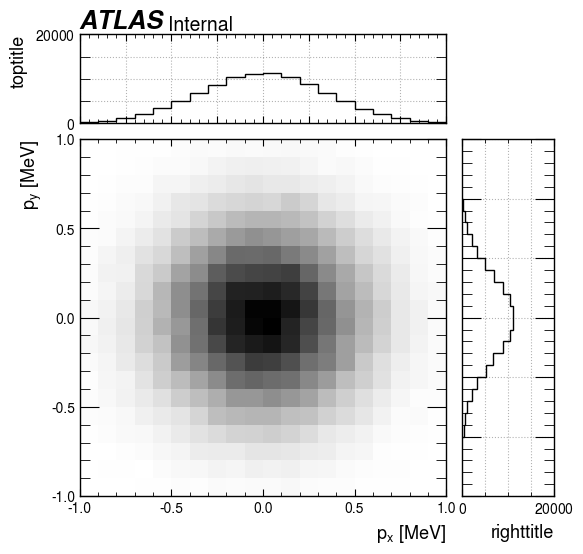

In [8]:
# my_dict={
#     'axes.titlesize': 20,
#     'xaxis.labellocation': 'center',
#     'yaxis.labellocation': 'center',
# }

plot = ProjectionPlot(hist)
plot.figure_options(figsize=(6,6), spacing=0.07)
plot.plot_options('both:')
plot.set_axislabels(13, ymain=r'$p_y$ [MeV]', xmain=r'$p_x$ [MeV]', xright='righttitle', ytop='toptitle')
plot.color_options(colormap='binary')
plot.create()
# plot.saveimage("ProjectionPlot_demo_binary", 1000)